In [28]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py, cv2
from IPython.display import clear_output
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, print_wise
from image_processing.utils import read_video
from image_processing.gaze_dep_models import pad_frame, extract_square_patch

In [40]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 20
    fs = 50
    
cfg = Cfg()

In [41]:
def load_eyetracking_data(paths, sub_num, run, fs, xy=True, ):
    eyetracking_dir = f"{paths['data_dir']}/data/eyetracker_data"
    eyetracking_file = f"{eyetracking_dir}/gaze_sub{sub_num:03d}_run{run:02d}_{fs}Hz.mat"
    with h5py.File(eyetracking_file, "r") as f:
        gaze = f['gaze'][:].T
        timestamps = f['tNew'][:].T
    # end with h5py.File(eyetracking_file, "r") as f:
    if xy:
        gaze = gaze[:2, :]
    # end if xy:
    gaze = TimeSeries(gaze, fs)
    return gaze, timestamps

In [42]:
run = 1
eyetracking_dir = f"{paths['data_dir']}/data/eyetracker_data"
eyetracking_file = f"{eyetracking_dir}/gaze_sub{cfg.sub_num:03d}_run{run:02d}_{cfg.fs}Hz.mat"

In [44]:
g, ts = load_eyetracking_data(paths, cfg.sub_num, run, cfg.fs, xy=True)
g.resample(23.98)    
g.set_array(np.round(g.get_array()).astype(int))

In [6]:
v = read_video(paths, 0, 1, vid_duration=40)


07:31:23 - rank 0 /Users/tizianocausin/1917_local/stimuli/Project1917_movie_part1_24Hz.mp4 read successfully


In [7]:
nframes, h, w, c = v.shape
print(h, w)

522 1280


In [63]:
43692/50

873.84

In [62]:
frame_count/23.98 - 5

873.7322768974145

In [59]:
print(frame_count -121)

20951.0


In [53]:
subs = list(range(3, 24))
subs.extend([25, 28, 30, 31, 34])
for i in [1]:#,2, 3, 4, 5, 6]:
    for sub in subs: 
        g, ts = load_eyetracking_data(paths, cfg.sub_num, i, cfg.fs, xy=True)
        # g.resample(23.98)
        print(len(g))
    

43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692
43692


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def extract_circular_patch(canvas, cx, cy, radius, fill_value=128):
    """
    Extract a circular patch around (cx, cy) with radius.
    Pads with fill_value if circle goes outside canvas.
    
    canvas: (H, W, C) image
    cx, cy: center coordinates (pixels)
    radius: radius of circle (pixels)
    fill_value: value to fill outside canvas
    """
    H, W, C = canvas.shape
    diameter = 2 * radius
    
    # Initialize patch with fill_value
    patch = np.ones((diameter, diameter, C), dtype=canvas.dtype) * fill_value
    
    # Compute coordinates in canvas
    x_start_canvas = max(cx - radius, 0)
    x_end_canvas   = min(cx + radius, W)
    y_start_canvas = max(cy - radius, 0)
    y_end_canvas   = min(cy + radius, H)
    
    # Compute coordinates in patch
    x_start_patch = max(0, radius - cx)
    x_end_patch   = x_start_patch + (x_end_canvas - x_start_canvas)
    y_start_patch = max(0, radius - cy)
    y_end_patch   = y_start_patch + (y_end_canvas - y_start_canvas)
    
    # Copy pixels into patch
    patch[y_start_patch:y_end_patch, x_start_patch:x_end_patch, :] = \
        canvas[y_start_canvas:y_end_canvas, x_start_canvas:x_end_canvas, :]
    
    # Create circular mask
    Y, X = np.ogrid[:diameter, :diameter]
    dist_from_center = np.sqrt((X - radius)**2 + (Y - radius)**2)
    circle_mask = dist_from_center <= radius
    
    # Apply mask: everything outside circle -> fill_value
    patch[~circle_mask] = fill_value
    circle_pixels = patch[circle_mask]
    return circle_pixels#patch


In [ ]:
def read_video(paths, rank, movie_part, vid_duration=0):
    video_path = f"{paths['data_dir']}/stimuli/Project1917_movie_part{movie_part}_24Hz.mp4" 
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video file: {video_path}")

    
    video = np.zeros((frames_to_loop, height, width, 3), dtype=np.uint8) # standard [B, H, W, C]
    counter = 0
    total = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    for frame_idx in range(frames_to_loop):
        ret, frame = cap.read()
        if not ret:
            raise RuntimeError(f"Failed to read frame {counter} from {video_path}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video[frame_idx, :, :, :] = frame
        counter += 1
    # end while True
    print_wise(f"{video_path} read successfully", rank=rank)
    cap.release()
    return video


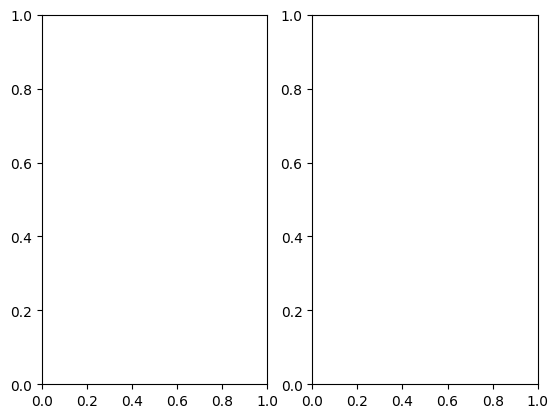

In [13]:
screen_res = (1080, 1920)
gray_value = 128  # mid-gray
sq_side = 224
sq_side_resized = 384
movie_dims = (h, w)
offset_dims = ((screen_res[0] -h)//2 , ( screen_res[1] - w)//2)
resHor, resVer = 1920, 1080
canvas = None
for idx, xy in enumerate(g):
    fig, ax = plt.subplots(1, 2)
    if idx == 200:
        break
    canvas = pad_frame(v[idx, :,:,:], movie_dims, offset_dims, canvas=canvas)
    # p = extract_circular_patch(canvas, xy[0], xy[1], 50, fill_value=128)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)
    ax[0].imshow(canvas)
    ax[0].scatter(xy[0], xy[1], color='green')
    ax[0].set_xlim(0, resHor)
    ax[0].set_ylim(resVer, 0)
    ax[1].imshow(p)
    plt.show()
    clear_output(wait=True)

In [50]:
print(frame_count - len(g))


117.0


In [ ]:
frame_count/23

20955

In [52]:
117/5

23.4

In [38]:
5*23.98

119.9

In [25]:
movie_part = 1
video_path = f"{paths['data_dir']}/stimuli/Project1917_movie_part{movie_part}_24Hz.mp4" 
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video file: {video_path}")
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
assert frame_count == len(g)
for idx, xy in enumerate(g):
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError(f"Failed to read frame {idx} from {video_path}")

    canvas = pad_frame(v[idx, :,:,:], movie_dims, offset_dims, canvas=canvas)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)

AssertionError: 

In [15]:
with h5py.File("/Volumes/TIZIANO/models/Project1917_resnet18_run05.h5", "r") as f:
    print(f.keys())



<KeysViewHDF5 ['fc', 'layer1', 'layer2', 'layer3', 'layer4']>


In [34]:
from scipy.io import loadmat
a = loadmat("/Volumes/TIZIANO/models/Project1917_real_alexnet_real_fc_layer2_run01_movie24Hz.mat")['vecrep']

In [37]:
a.shape

(933, 20953)

In [ ]:
from einops import rearrange

In [51]:
v_vec = TimeSeries(rearrange(v, 'b h w c -> (h w c) b'), 23.98)
v_vec.resample(50)

In [56]:
for f in v_vec:
    f = f.reshape(522, 1280, 3)           
    plt.imshow(f)
    plt.show()
    clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
for idx, xy in enumerate(g):
    fig, ax = plt.subplots(1, 2)
    if idx == 200:
        break
    canvas = pad_frame(v[idx, :,:,:], movie_dims, offset_dims, canvas=canvas)
    # p = extract_circular_patch(canvas, xy[0], xy[1], 50, fill_value=128)
    p = extract_square_patch(canvas, xy[0], xy[1], sq_side)#, fill_value=128)
    resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)

In [24]:
200*200*3*20000*8/10**9

19.2